
--- Base SVR Model (multivariate) ---
MSE: 8.6585, RMSE: 2.9425, MAE: 2.3425, R²: 0.8637, MAPE: 90.89%

Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV completed.

Best Hyperparameters found: {'C': np.float64(82.26074946221037), 'epsilon': np.float64(0.0176979909828793), 'gamma': np.float64(0.0007400385759087378), 'kernel': 'rbf'}

--- Tuned SVR Model (multivariate) ---
MSE: 5.2854, RMSE: 2.2990, MAE: 1.7937, R²: 0.9168, MAPE: 64.76%


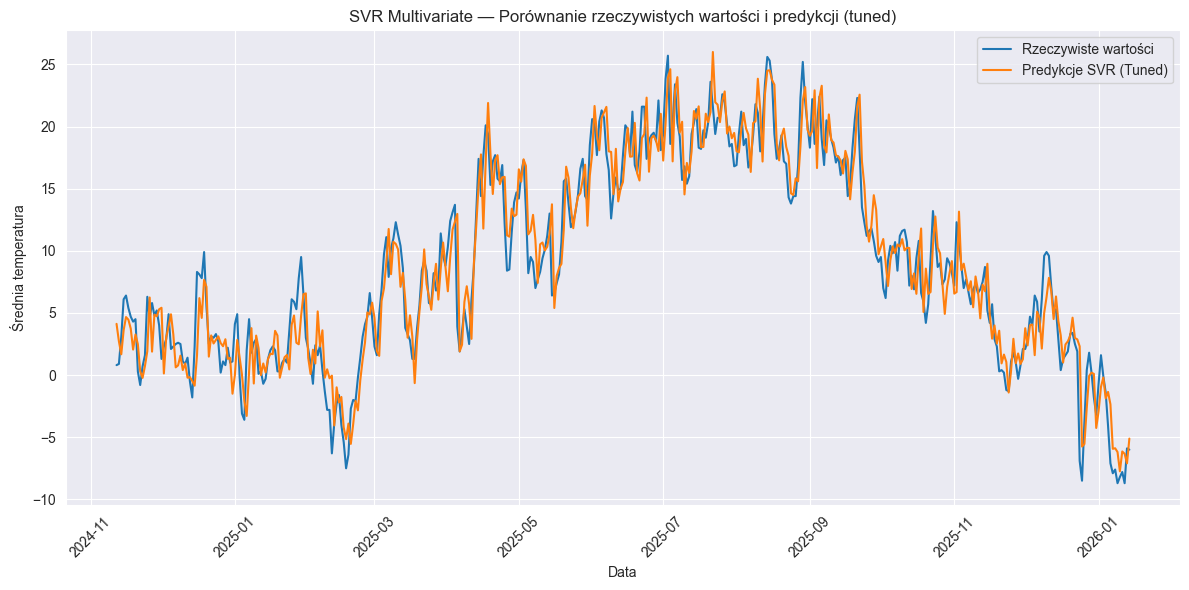

In [52]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import loguniform, uniform
import matplotlib.pyplot as plt

# =========================
# Parametry
# =========================
WINDOW = 60
HORIZON = 1  # predykcja 1 dzień
FEATURES = ['temp','tmin','tmax','wspd','pres','temp_rolling3','temp_diff1']

# =========================
# Wczytanie danych
# =========================
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])
df_city = df[df['city'] == 'Warszawa'][['time'] + FEATURES].copy()
df_city.sort_values("time", inplace=True)
df_city.reset_index(drop=True, inplace=True)

# =========================
# Tworzenie sekwencji wielowymiarowych
# =========================
def create_multivariate_sequences(df, features, window=WINDOW):
    X, y = [], []
    data = df[features].values
    temps = df['temp'].values
    for i in range(len(df) - window):
        seq = data[i:i+window].flatten()  # spłaszczamy wszystkie cechy w jeden wektor
        X.append(seq)
        y.append(temps[i + window])
    return np.array(X), np.array(y)

X, y = create_multivariate_sequences(df_city, FEATURES, WINDOW)

# =========================
# Skalowanie danych
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

# =========================
# Podział na trening i test
# =========================
train_size = int(len(X_scaled) * 0.8)
X_train_scaled = X_scaled[:train_size]
X_test_scaled  = X_scaled[train_size:]
y_train_scaled = y_scaled[:train_size]
y_test_scaled  = y_scaled[train_size:]

# =========================
# Base SVR
# =========================
base_svr = SVR(kernel='rbf', C=10000, gamma='scale')
base_svr.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_scaled = base_svr.predict(X_test_scaled)
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).ravel()

mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + np.finfo(float).eps))) * 100

print("\n--- Base SVR Model (multivariate) ---")
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

# =========================
# RandomizedSearchCV - tuning SVR
# =========================
param_dist = {
    'C': loguniform(1e1, 1e5),
    'gamma': loguniform(1e-4, 1e-1),
    'epsilon': uniform(0.01, 0.1),
    'kernel': ['rbf']
}

random_search = RandomizedSearchCV(
    estimator=SVR(),
    param_distributions=param_dist,
    n_iter=50,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

print("\nStarting RandomizedSearchCV...")
random_search.fit(X_train_scaled, y_train_scaled.ravel())
print("RandomizedSearchCV completed.")

best_params = random_search.best_params_
print("\nBest Hyperparameters found:", best_params)

# =========================
# SVR z najlepszymi hiperparametrami
# =========================
best_svr = SVR(**best_params)
best_svr.fit(X_train_scaled, y_train_scaled.ravel())
y_pred_scaled_tuned = best_svr.predict(X_test_scaled)
y_pred_original_tuned = scaler_y.inverse_transform(y_pred_scaled_tuned.reshape(-1,1)).ravel()

mse_tuned = mean_squared_error(y_test_original, y_pred_original_tuned)
rmse_tuned = np.sqrt(mse_tuned)
mae_tuned = mean_absolute_error(y_test_original, y_pred_original_tuned)
r2_tuned = r2_score(y_test_original, y_pred_original_tuned)
mape_tuned = np.mean(np.abs((y_test_original - y_pred_original_tuned) / (y_test_original + np.finfo(float).eps))) * 100

print("\n--- Tuned SVR Model (multivariate) ---")
print(f"MSE: {mse_tuned:.4f}, RMSE: {rmse_tuned:.4f}, MAE: {mae_tuned:.4f}, R²: {r2_tuned:.4f}, MAPE: {mape_tuned:.2f}%")

# =========================
# Wykres rzeczywiste vs predykcje
# =========================
plt.figure(figsize=(12,6))
plt.plot(df_city['time'].iloc[-len(y_test_original):], y_test_original, label='Rzeczywiste wartości')
plt.plot(df_city['time'].iloc[-len(y_pred_original_tuned):], y_pred_original_tuned, label='Predykcje SVR (Tuned)')
plt.xlabel("Data")
plt.ylabel("Średnia temperatura")
plt.title("SVR Multivariate — Porównanie rzeczywistych wartości i predykcji (tuned)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [60]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

# =========================
# Parametry
# =========================
WINDOW = 60
HORIZON = 5
FEATURES = ['temp','tmin','tmax','wspd','pres','temp_rolling3','temp_diff1']

# =========================
# Wczytanie danych
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])
df_city = df[df['city'] == 'Warszawa'][['time'] + FEATURES].copy()
df_city.sort_values("time", inplace=True)
df_city.reset_index(drop=True, inplace=True)

# =========================
# Tworzenie sekwencji wielowymiarowych
# =========================
def create_multivariate_sequences(df, features, window=WINDOW):
    X, y = [], []
    data = df[features].values
    temps = df['temp'].values
    for i in range(len(df) - window):
        seq = data[i:i+window].flatten()
        X.append(seq)
        y.append(temps[i + window])
    return np.array(X), np.array(y)

X, y = create_multivariate_sequences(df_city, FEATURES, WINDOW)

# =========================
# Skalowanie danych
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))

# =========================
# Trening finalnego SVR na wszystkich danych
# =========================
best_params = {'kernel':'rbf','C':82.26,'gamma':0.00074,'epsilon':0.0177}
svr_final = SVR(**best_params)
svr_final.fit(X_scaled, y_scaled.ravel())

# =========================
# Prognoza 5 dni do przodu na końcu danych
# =========================
last_window = df_city.iloc[-WINDOW:].copy()

future_forecast_scaled = []

for i in range(HORIZON):
    # Tworzymy sekwencję z ostatnich WINDOW dni
    seq = last_window[FEATURES].values.flatten().reshape(1,-1)
    seq_scaled = scaler_X.transform(seq)
    
    # Prognoza
    y_pred_scaled = svr_final.predict(seq_scaled)[0]
    future_forecast_scaled.append(y_pred_scaled)
    
    # Odwrócenie skalowania do obliczeń dla nowych cech
    y_pred = scaler_y.inverse_transform(np.array([[y_pred_scaled]])).flatten()[0]
    
    # Aktualizacja last_window
    new_row = last_window.iloc[-1].copy()
    new_row['temp'] = y_pred
    
    # Aktualizacja cech zależnych
    temps_for_roll = list(last_window['temp'].iloc[-2:].values) + [y_pred] if len(last_window)>=2 else [y_pred]
    new_row['temp_rolling3'] = np.mean(temps_for_roll[-3:])
    new_row['temp_diff1'] = y_pred - last_window['temp'].iloc[-1]
    
    # Przesuwamy okno o 1 dzień
    last_window = pd.concat([last_window.iloc[1:], new_row.to_frame().T], ignore_index=True)

# Odwrócenie skalowania do temperatur
future_forecast = scaler_y.inverse_transform(np.array(future_forecast_scaled).reshape(-1,1)).flatten()
future_dates = pd.date_range(start=df_city['time'].iloc[-1] + pd.Timedelta(days=1), periods=HORIZON, freq='D')

print("\nPrognoza 5 dni do przodu na końcu danych:")
for date, temp in zip(future_dates, future_forecast):
    print(f"{date.date()} -> {temp:.2f} °C")



Prognoza 5 dni do przodu na końcu danych:
2026-01-15 -> -5.08 °C
2026-01-16 -> -3.80 °C
2026-01-17 -> -2.30 °C
2026-01-18 -> -3.58 °C
2026-01-19 -> -2.75 °C


17:20:02 - cmdstanpy - INFO - Chain [1] start processing
17:20:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Metryki Prophet (Cross-Validation):
R²   : 0.9960
MSE  : 0.2800
RMSE : 0.5287
MAE  : 0.4128


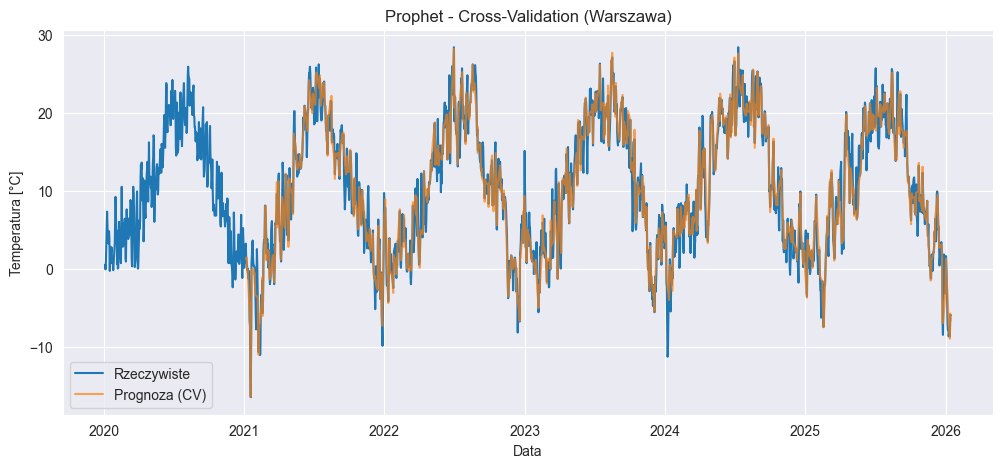

In [46]:
import os
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# =========================
# 1. Wczytanie danych
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])

# =========================
# =========================
# 1. Filtracja miasta i przygotowanie danych
# =========================
cols_needed = ['time','temp','tmin','tmax','prcp','wspd','pres','temp_rolling3','temp_diff1']
df_city = df[df['city']=='Warszawa'][cols_needed].copy()
df_city.sort_values("time", inplace=True)
df_city.rename(columns={'time':'ds','temp':'y'}, inplace=True)

# =========================
# 2. Definicja modelu Prophet z regresorami
# =========================
model = Prophet(
    yearly_seasonality=15,
    weekly_seasonality=10,
    daily_seasonality=False,
    changepoint_prior_scale=0.1
)

# Sezonowość miesięczna
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Dodanie regresorów
regressors = ['tmin','tmax','prcp','wspd','pres','temp_rolling3','temp_diff1']
for reg in regressors:
    model.add_regressor(reg)
model.fit(df_city)
# =========================
# 3. Trenowanie modelu
# =========================


# =========================
# 4. Cross-Validation
# =========================
df_cv = cross_validation(
    model,
    initial='365 days',
    period='10 days',
    horizon='5 days',
    parallel="processes"
)

# =========================
# 5. Obliczenie metryk + R² ręcznie
# =========================
df_p = performance_metrics(df_cv)
y_true = df_cv['y'].values
y_pred = df_cv['yhat'].values
r2 = r2_score(y_true, y_pred)

print("Metryki Prophet (Cross-Validation):")
print(f"R²   : {r2:.4f}")
print(f"MSE  : {df_p['mse'].mean():.4f}")
print(f"RMSE : {df_p['rmse'].mean():.4f}")
print(f"MAE  : {df_p['mae'].mean():.4f}")

# =========================
# 6. Wykres rzeczywiste vs prognozy
# =========================
plt.figure(figsize=(12,5))
plt.plot(df_city['ds'], df_city['y'], label='Rzeczywiste')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Prognoza (CV)', alpha=0.7)
plt.title("Prophet - Cross-Validation (Warszawa)")
plt.xlabel("Data")
plt.ylabel("Temperatura [°C]")
plt.legend()
plt.grid(True)
plt.show()


In [54]:
# =========================
# Prognoza na następne 5 dni
# =========================
future = model.make_future_dataframe(periods=5)

# 🔹 Dodanie regresorów dla przyszłości
# Tutaj użyjemy ostatnich wartości z df_city jako przybliżenia
for reg in regressors:
    last_values = df_city[reg].iloc[-5:].values
    if len(last_values) < 5:
        # jeśli mniej niż 5 dni danych, powtarzamy ostatnią wartość
        last_values = [df_city[reg].iloc[-1]] * 5
    # rozszerzamy kolumnę regresora
    future[reg] = pd.concat([df_city[reg], pd.Series(last_values)]).reset_index(drop=True).iloc[-len(future):]

# Generowanie prognozy
forecast = model.predict(future)

# =========================
# Wyświetlenie prognozy 5 dni
# =========================
forecast_5days = forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(5)
print("Prognoza 5 dni do przodu (Warszawa):")
print(forecast_5days)

# =========================
# Wykres rzeczywiste vs prognoza
# =========================
plt.figure(figsize=(12,5))
plt.plot(df_city['ds'], df_city['y'], label='Rzeczywiste')
plt.plot(forecast_5days['ds'], forecast_5days['yhat'], label='Prognoza 5 dni', marker='o')
plt.fill_between(forecast_5days['ds'], forecast_5days['yhat_lower'], forecast_5days['yhat_upper'], 
                 color='orange', alpha=0.2, label='Przedział ufności')
plt.title("Prophet - prognoza 5 dni do przodu (Warszawa)")
plt.xlabel("Data")
plt.ylabel("Temperatura [°C]")
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'prcp'

In [16]:
import seaborn as sns
import numpy as np

# =========================
# Predykcja na zbiorze testowym SVR
# =========================
y_pred_scaled = best_svr.predict(X_test).reshape(-1,1)

# Odwrócenie skalowania
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Dopasowanie długości (czasem może być minimalna różnica)
min_len = min(len(y_test_rescaled), len(y_pred_rescaled))
y_test_rescaled = y_test_rescaled[:min_len]
y_pred_rescaled = y_pred_rescaled[:min_len]

# =========================
# Obliczenie residuals
# =========================
residuals = y_test_rescaled - y_pred_rescaled

# =========================
# Wykres residuals w czasie
# =========================
plt.figure(figsize=(12,6))
plt.plot(
    df_city['date'].iloc[-len(residuals):],
    residuals,
    marker='o',
    linestyle='-',
    color='g'
)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals modelu SVR — błąd predykcji w czasie')
plt.xlabel('Data')
plt.ylabel('Błąd predykcji (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# Histogram residuals
# =========================
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True, color='g')
plt.title('Rozkład residuals modelu SVR')
plt.xlabel('Błąd predykcji (°C)')
plt.ylabel('Częstość')
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: X has 60 features, but SVR is expecting 180 features as input.

In [38]:
from sklearn.multioutput import MultiOutputRegressor

# Tworzenie etykiet multi-step (5 dni)
forecast_horizon = 5
X_multi, y_multi = [], []
for i in range(len(df_city) - window - forecast_horizon + 1):
    X_multi.append(df_city['temp'].iloc[i:i+window].values)
    y_multi.append(df_city['temp'].iloc[i+window:i+window+forecast_horizon].values)
X_multi = np.array(X_multi)
y_multi = np.array(y_multi)

# Skalowanie
X_scaled = scaler_X.fit_transform(X_multi)
y_scaled = scaler_y.fit_transform(y_multi)
y_scaled = np.array(y_scaled)

# Trening MultiOutput SVR
multi_svr = MultiOutputRegressor(SVR(kernel='rbf', C=1232.91, gamma=0.0001192, epsilon=0.05275))
multi_svr.fit(X_scaled, y_scaled)

# Predykcja 5 dni od razu
last_window = X_scaled[-1].reshape(1, window)
future_scaled = multi_svr.predict(last_window)
future_pred = scaler_y.inverse_transform(future_scaled)
print("Prognoza 5 dni (multi-output SVR):")
print(future_pred.flatten())


KeyError: 'temp'